# **Light Field Estimation - Phong Model**
## Course "Digital Image Processing"

---

Students: Festoni Luca - Gozzoli Mattia - Rubagotti Matteo

# Import & Drive Setup

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import random
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from PIL import Image
import os
from google.colab import drive

In [ ]:
drive.mount("/content/drive", force_remount=True)
data_path = "/content/drive/My Drive/Progetto DIP/Data" # Edit the path where are stored images

Mounted at /content/drive


#  Main Utils Functions


1.   **show_image**: function to print out an image
     * **INPUT**: 
      * **image**: the image
      * **title**: a title for the print
2.  **test_normal_vector**: function to test/draw a random normal vector found by derivative_approx()
     * **INPUT**: 
      * **img**: the image
      * **pixels**: a title for the print
      * **angles_n**: list of normal vectors angles
      * **angles_t**: list of tangent vectors angles
3.  **draw_normal_vectors**: function to draw the normal vectors on the image
     * **INPUT**:
      * **img**: the image where to draw the vectors
      * **pixel_list**: list of the pixels of the contour
      * **angles_n**: list of normal vectors angles
      * **scale**: multiplying factor for drawing
     * **OUTPUT**:
      * **img_with_vectors**: the image with normal vectors drawn

In [ ]:
def show_image(image, title):
    if(len(image.shape) == 2):
        plt.imshow(image, cmap = 'gray', interpolation = 'bicubic', vmin=0, vmax=255)
    else:
        plt.imshow(image, interpolation = 'bicubic', vmin=0, vmax=255)
    
    plt.title(title)
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()

In [ ]:
def test_normal_vector(img, pixels, angles_n, angles_t):
  
  height = img.shape[0]   # Get the height of the image
  width = img.shape[1]    # Get the width of the image

  img_ = img.copy()       # Get a copy of the image to work with

  r = random.randrange(0, len(pixels))  # Get a random value to select a rando pixel and its normal/tangent vectors
  y = pixels[r][1]
  x = pixels[r][0]

  cv2.circle(img_, (x,y), 8, (0,0,255)) # Draw a circle on the pixel selected (randomly)

  show_image(img_, "PIXEL SELECTED")

  # Start point coordinate
  start_point = (x,y)
    
  # End point coordinate
  scale = 100
  angle_n = angles_n[r]
  angle_t = angles_t[r]

  end_point_n = (math.floor(x + 1*math.cos(angle_n)*scale), math.floor(y + 1*math.sin(angle_n)*scale))
  end_point_t = (math.floor(x + 1*math.cos(angle_t)*scale/2), math.floor(y + 1*math.sin(angle_t)*scale/2))

  thickness = 3 # Line thickness of arrow

  # Draw arrows
  edges_ = cv2.arrowedLine(img_, start_point, end_point_n, (255,255,255), thickness)   # white
  edges_ = cv2.arrowedLine(img_, start_point, end_point_t, (0,255,0), thickness)       # green

  print("Start point:", start_point)
  print("End point (N):", end_point_n)
  print("End point (T):", end_point_t)
  print("Angle (N) =", np.rad2deg(angle_n))    # angle of normal vector
  print("Angle (T) =", np.rad2deg(angle_t))    # angle of tangent vector

  show_image(img_, "")
  #return True

In [ ]:
def draw_normal_vectors(img, pixel_list, angles_n, scale):
  img_with_vectors = img.copy()

  for i in range(len(pixel_list)):
    x = pixel_list[i][0]
    y = pixel_list[i][1]

    angle_n = angles_n[i]     # Angle of normal vector
    end_point_n = (math.floor(x + 1*math.cos(angle_n)*scale), math.floor(y + 1*math.sin(angle_n)*scale))

    img_with_vectors = cv2.arrowedLine(img_with_vectors, (x,y), end_point_n, (0,255,255), 2)

  show_image(img_with_vectors, "")
  return img_with_vectors

# FUNCTION: DERIVATIVE_APPROX

**WHAT IT DOES**: derivate approximation using polynomial interpolation (degree 1), considering 5 pixels, the previus 2 and the subsequent 2 of a central pixel 
* **INPUT**:
  * **points**: list of contour pixels to compute np.polyfit()
  * **contours**: contours of the image
  * **DEG**: degree of interpolation
* **OUTPUT**:
  * **angles_n**: normal vectors angles
  * **angles_t**: tangent vectors angles
  * **pixels**: selected pixels of contour


In [ ]:
def derivative_approx(points, contours, DEG=1):

  # Initialization
  angles_n = [] # initialize the list of angles of normal vector at each pixel of contour
  angles_t = [] # initialize the list of angles of tangent vector at each pixel of contour
  pixels = [] # initialize the list of non-duplicate & sorted pixels of contour

  pixel_list = list(set(points)) # remove duplicates pixels (tuple)
  pixel_list = sorted(pixel_list, key=lambda tup: tup[0]) # sort by x-axis coordinates

  x_list = [a_tuple[0] for a_tuple in pixel_list] # list of x-axis coordinates sorted
  y_list = [a_tuple[1] for a_tuple in pixel_list] # list of y-axis coordinates sorted (according to x)

  x_list_unique = []  # list for unique x coordinates
  y_list_unique = []  # list for unique y coordinates (according to x)

  # Remove all duplicates coordinates with the same x-axis (i.e. vertical lines)
  for i in range(len(x_list)): 
    if x_list[i] not in x_list_unique:
      x_list_unique.append(x_list[i])
      y_list_unique.append(y_list[i])

  x_list = x_list_unique
  y_list = y_list_unique

  # Create a list of tuples of edge pixels selected
  for i in range(len(x_list)):
    pixels.append(tuple((x_list[i], y_list[i])))

  print(pixels, "\n Number of edge pixel selected =", len(pixels))

  # Polynomial interpolation for each set of points, taking the previous 2 pixels and the subsequent 2 pixels
  for i in range(2, len(x_list) - 2):
    x = [x_list[i-2], x_list[i-1], x_list[i], x_list[i+1], x_list[i+2]]
    y = [y_list[i-2], y_list[i-1], y_list[i], y_list[i+1], y_list[i+2]]

    p = np.polyfit(x, y, DEG)   # polynomial coefficients (np.array(shape = (deg+1))
    m = p[0]                    # first derivative deg = 1 
    m_orthogonal = -1/m         # angular coefficient of normal vector

    angle = math.atan2(m_orthogonal, 1)   # get the angle
    angles_n.insert(i, angle)             # append normal vector angle to a list
    angles_t.insert(i, math.atan2(m, 1))  # append tangent vector angle to a list

  # Exclude first & last 2 pixels from the interpolation
  pixels.pop(0)
  pixels.pop(1)
  pixels.pop(len(pixels) - 1)
  pixels.pop(len(pixels) - 2)

  return angles_n, angles_t, pixels

#FUNCTION: FIND_CONTOURS

**WHAT IT DOES**: given a grayscale image and a threshold it tries to combine different inner function to find the contours of an image.
* **INPUT**:
  * **img_gray**: a grayscale image
  * **thresh**: a threshold to use for Canny Edge Detection and Threshold function
* **OUTPUT**:
  * **drawing**: image of contours (e.g. 255 if [y,x] is contour; 0 otherwise)
  * **contours**: array of list of pixels for any part of edge


In [ ]:
def find_contours(img_gray, thresh):
  # Edge detection
  canny_output = cv2.Canny(img_gray, thresh, thresh*2)

  # Get threshold image
  _, thresh_img = cv2.threshold(canny_output, thresh, 255, cv2.THRESH_BINARY)

  # Find contours 
  # contours is an array of all the coordinates of the edge of input image
  contours, hierarchy = cv2.findContours(thresh_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

  # Drawing contours of the image
  color = (255,255,255)                                                                 # color of the contours
  drawing = np.zeros((canny_output.shape[0], canny_output.shape[1]), dtype=np.uint8)    # initialize contours image

  # Generate contours map
  for i in range(len(contours)):
    cv2.drawContours(drawing, contours, i, color)

  img_copy = img_gray.copy()  # create a copy of the image to work with

  # Drawing contours on the original image
  for i in range(len(contours)):
    cv2.drawContours(img_copy, contours, i, (255,255,0), 2, cv2.LINE_8, hierarchy, 0)

  show_image(img_gray, "Input Image")
  show_image(drawing, "")
  im = Image.fromarray(drawing)
  im.save("contours.png")
  show_image(img_copy, "")
  im = Image.fromarray(img_copy)
  im.save("img+contours.png")
  
  return drawing, contours

# FUNCTION: BACKGROUND_MASK
  **WHAT IT DOES**: given an image, 2 threshold values for Edge detection, a value for the BLUR filter and the number of dilation and erode iteration it tries to set all the background pixel to black.
  This function is used to invert normal vectors  which point in the wrong direction.
* **INPUT**:
  * **img**: an image
  * **CANNY_THRESH_1**: Low threshold for canny edge detection
  * **CANNY_THRESH_2**: High threshold for canny edge detection
  * **BLUR**: kernel dimension for Blur filter
  * **MASK_DILATE_ITER** = number of dilation iterations
  * **MASK_ERODE_ITER** = number of erosion iterations
* **OUTPUT**:
  * **masked**: the image with the background set to black


In [ ]:
def background_mask(img,CANNY_THRESH_1 = 21,CANNY_THRESH_2 = 200,BLUR = 21,MASK_DILATE_ITER = 10, MASK_ERODE_ITER = 12):
  MASK_COLOR = (0,0,0) # In BGR format
  # Color chosen for the background is BLACK fo semplicity, if the object to surround is pure black
  # another color has to be chosen for the background

  # Read image
  img = cv2.imread(data_path + "/sphere.png") # Edit file name of the input image
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  # Edge detection
  edges = cv2.Canny(gray, CANNY_THRESH_1, CANNY_THRESH_2)
  edges = cv2.dilate(edges, None)
  edges = cv2.erode(edges, None)

  # Find contours in edges, sort by area
  contour_info = []
  contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

  for c in contours:
    contour_info.append((
        c,
        cv2.isContourConvex(c),
        cv2.contourArea(c),
    ))
  contour_info = sorted(contour_info, key=lambda c: c[2], reverse=True)
  max_contour = contour_info[0]

  # Create empty mask, draw filled polygon on it corresponding to largest contour, Mask is black, polygon is white
  mask = np.zeros(edges.shape)
  cv2.fillConvexPoly(mask, max_contour[0], (255))

  # Smooth mask, then blur it
  mask = cv2.dilate(mask, None, iterations=MASK_DILATE_ITER)
  mask = cv2.erode(mask, None, iterations=MASK_ERODE_ITER)
  mask = cv2.GaussianBlur(mask, (BLUR, BLUR), 0)
  mask_stack = np.dstack([mask]*3)    # Create 3-channel alpha mask

  # Blend masked img into MASK_COLOR background
  mask_stack  = mask_stack.astype('float32') / 255.0            # Use float matrices, 
  img         = img.astype('float32') / 255.0                   # For easy blending

  masked = (mask_stack * img) + ((1 - mask_stack) * MASK_COLOR) # Blend
  masked = (masked * 255).astype('uint8')                       # Convert back to 8-bit 

  show_image(masked, "BACKGROUND MASK")                         # Display

  return masked

# FUNCTION: FIX_NORMAL_DIRECTION
  **WHAT IT DOES**: This function is used to invert normal vectors  which point in the wrong direction.
Given the pixel list, the normal vectors angles, the background mask a scale to fit the vectors to the background mask, it invert the normal vectors that do not point outward from the figure.
* **INPUT**:
  * **pixel_list**: list of the pixels of the contour
  * **angles_n**: list of normal vectors angles
  * **mask**: the background mask, obtained using the corresponding function
  * **scale_**: a value to use for fitting the normal vectors dimension
* **OUTPUT**:
  * the same "angles_n" list with the correct values

In [ ]:
def fix_normal_direction(pixel_list, angles_n, mask, scale_):
  mask_copy = mask.copy()
  mask_gray = cv2.cvtColor(mask_copy, cv2.COLOR_BGR2GRAY)

  for i in range(len(pixel_list)):
    # Edge pixel coordinates
    x = pixel_list[i][0]
    y = pixel_list[i][1]

    # Normal vector direction components
    x_ = math.floor(x + math.cos(angles_n[i])*scale_)   # Scale to fix direction of normal vector
    y_ = math.floor(y + math.sin(angles_n[i])*scale_)   # Scale to fix direction of normal vector

    if mask_gray[y_,x_] != 0:
      angles_n[i] = angles_n[i] + np.deg2rad(180)

  return True



---


**MAIN CODE SECTION**

---







# STEP 1: READ & PRE-PROCESSING INPUT IMAGE
This is the main section to edit in order to testing PHONG model by using different images.

The steps executed here are:
1.   Import the image and get a greyscale version
2.   Get the **contour**
3.   Divide the image into **section** and for each one prepare a list with the    
corresponding pixels
4.   Use the ***derivative_approx*** function for each section of pixels in order to get the **tangent vectors angles** and the **normal vectors angles**





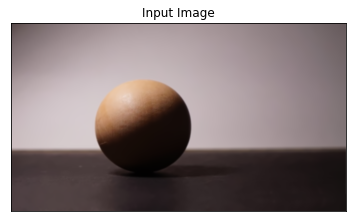

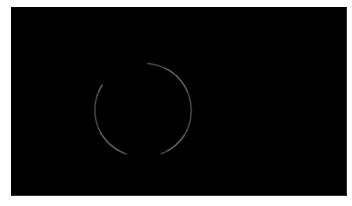

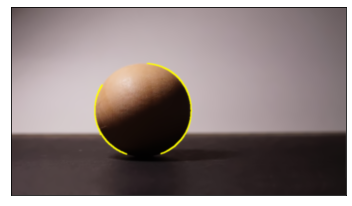

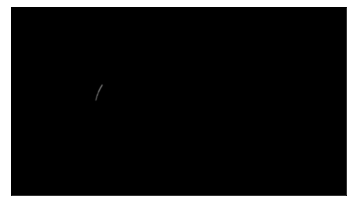

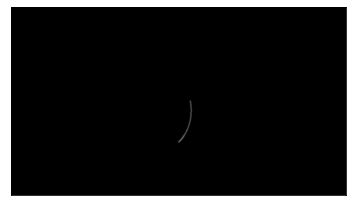

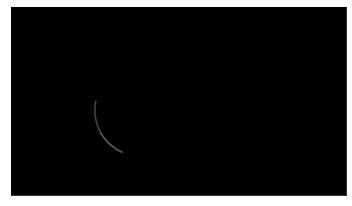

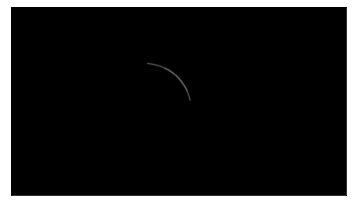

[(194, 214), (195, 213), (196, 206), (197, 205), (198, 201), (199, 199), (200, 197), (201, 193), (202, 191), (203, 191), (204, 188), (205, 185), (206, 185), (207, 184), (208, 180), (209, 180)] 
 Number of edge pixel selected = 16
[(384, 310), (385, 309), (386, 308), (387, 308), (388, 307), (389, 306), (390, 304), (391, 303), (392, 301), (393, 301), (394, 298), (395, 298), (396, 297), (397, 295), (398, 293), (399, 292), (400, 289), (401, 287), (402, 284), (403, 284), (404, 282), (405, 279), (406, 276), (407, 274), (408, 271), (409, 265), (410, 264), (411, 219), (412, 252), (413, 237)] 
 Number of edge pixel selected = 30
[(192, 241), (193, 224), (194, 259), (195, 265), (196, 266), (197, 272), (198, 274), (199, 275), (200, 279), (201, 281), (202, 283), (203, 286), (204, 287), (205, 289), (206, 291), (207, 293), (208, 293), (209, 295), (210, 296), (211, 298), (212, 300), (213, 300), (214, 303), (215, 304), (216, 304), (217, 306), (218, 307), (219, 308), (220, 309), (221, 310), (222, 312),

In [ ]:
img_path = "/sphere.png"                            # Path of the input image

img = cv2.imread(data_path + img_path, cv2.IMREAD_UNCHANGED)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)          # format input image with 3 channel (i.e. color RGB) to visualize results of any computation-step
img = cv2.fastNlMeansDenoising(img)                 # remove white noise
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)    # input image with 1 channel (i.e. grayscale)

# Get the contours of the input image
drawing, contours = find_contours(img, 150)

drawing_ = drawing.copy()

height, width = drawing.shape[0], drawing.shape[1]  # Size of input image

# =============================================================================
# Choose the number of subsections to divide the image into:
# Here we choose to use 4 section
# =============================================================================

# List of edge pixels
edge_pixels_1, edge_pixels_2, edge_pixels_3, edge_pixels_4 = [], [], [], []
# Divide the sphere into 4 arcs of circle
section_1, section_2, section_3, section_4 = np.zeros((height,width)), np.zeros((height,width)), np.zeros((height,width)), np.zeros((height,width))

# Fill the list of edge pixels for each section (#section = 4)
for i in range(math.floor(height/2)):
  for j in range(math.floor(width/3)):
    if drawing_[i,j]:
      edge_pixels_1.append(tuple((j,i)))
      section_1[i,j] = 255

for i in range(math.floor(height/2), height, 1):
  for j in range(math.floor(width/2), width, 1):
    if drawing_[i,j]:
      edge_pixels_2.append(tuple((j,i)))
      section_2[i,j] = 255

for i in range(math.floor(height/2), height, 1):
  for j in range(math.floor(width/3)):
    if drawing_[i,j]:
      edge_pixels_3.append(tuple((j,i)))
      section_3[i,j] = 255

for i in range(math.floor(height/2)):
  for j in range(math.floor(width/3), width, 1):
    if drawing_[i,j]:
      edge_pixels_4.append(tuple((j,i)))
      section_4[i,j] = 255

# Save the images
show_image(section_1, "")
im = Image.fromarray(section_1)
im = im.convert('RGB')
im.save("edges1.png")
show_image(section_2, "")
im = Image.fromarray(section_2)
im = im.convert('RGB')
im.save("edges2.png")
show_image(section_3, "")
im = Image.fromarray(section_3)
im = im.convert('RGB')
im.save("edges3.png")
show_image(section_4, "")
im = Image.fromarray(section_4)
im = im.convert('RGB')
im.save("edges4.png")

# Compute the angle of normal/tangent vector for each edge pixel
angles_n_1, angles_t_1, pixel_list_1 = derivative_approx(edge_pixels_1, section_1)
angles_n_2, angles_t_2, pixel_list_2 = derivative_approx(edge_pixels_2, section_2)
angles_n_3, angles_t_3, pixel_list_3 = derivative_approx(edge_pixels_3, section_3)
angles_n_4, angles_t_4, pixel_list_4 = derivative_approx(edge_pixels_4, section_4)

# STEP 2: GRAPHICAL TESTING FOR RANDOM SINGLE PIXELS
The ***test_normal_vector*** function gets a random pixel value and, taking its corresponding normal and tangent vectors, print out the image with the pixel selected and the vectors.
This work is done for each of the four section in this case.

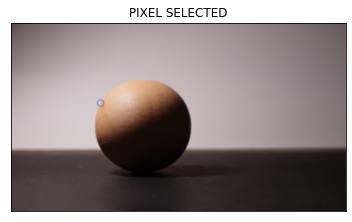

Start point: (205, 185)
End point (N): (291, 235)
End point (T): (230, 141)
Angle (N) = 30.465544919460136
Angle (T) = -59.53445508053987


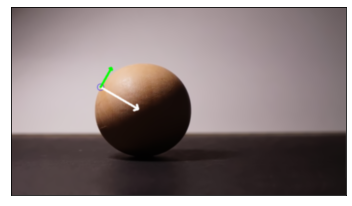

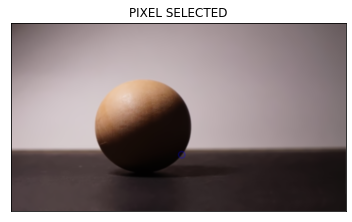

Start point: (391, 303)
End point (N): (470, 363)
End point (T): (421, 263)
Angle (N) = 37.56859202882701
Angle (T) = -52.431407971172995


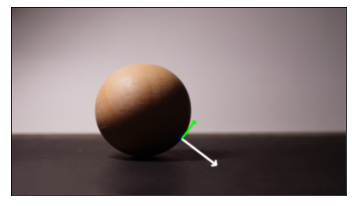

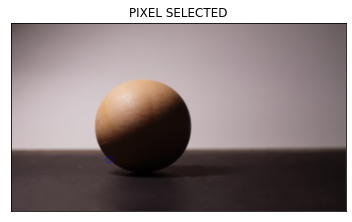

Start point: (225, 314)
End point (N): (287, 235)
End point (T): (264, 345)
Angle (N) = -51.34019174590914
Angle (T) = 38.65980825409086


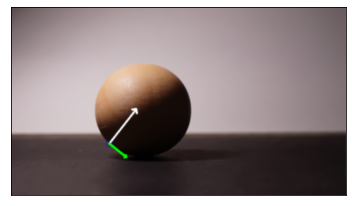

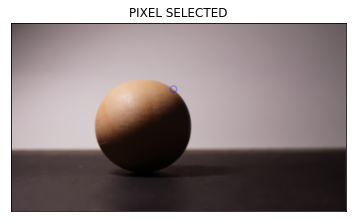

Start point: (372, 153)
End point (N): (429, 71)
End point (T): (412, 181)
Angle (N) = -55.00797980144159
Angle (T) = 34.99202019855841


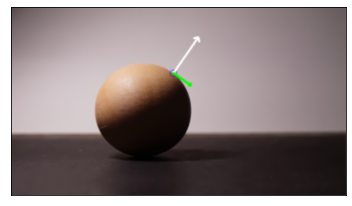

In [ ]:
# Draw normal/tangent vector of a random selected pixel of contour
# Call the function "test_normal_vector" for any subsections of the input image!
test_normal_vector(img, pixel_list_1, angles_n_1, angles_t_1)
test_normal_vector(img, pixel_list_2, angles_n_2, angles_t_2)
test_normal_vector(img, pixel_list_3, angles_n_3, angles_t_3)
test_normal_vector(img, pixel_list_4, angles_n_4, angles_t_4)

# STEP 3: FIX DIRECTION OF NORMAL VECTORS
After getting the background mask using ***background_mask*** function, in this section we applied the ***fix_normal_direction*** to each of the four section in order to get the correct normal vector direction.

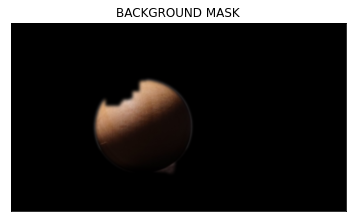

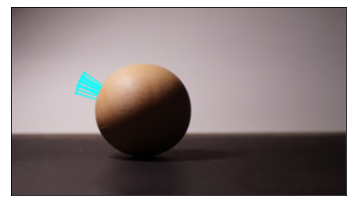

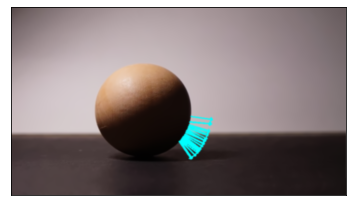

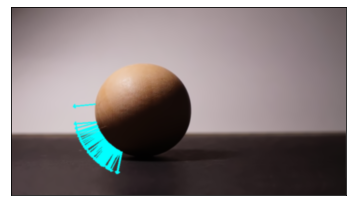

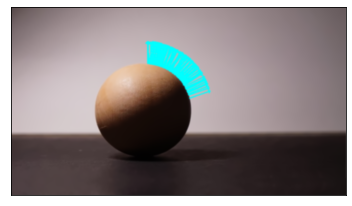

In [ ]:
# Get the background mask
masked = background_mask(img)

# Use fix_normal_direction function and draw_normal_vectors for any subsections created!
# Fix the direction of the normal vectors (for each section)
fix_normal_direction(pixel_list_1, angles_n_1, masked, scale_=10)
fix_normal_direction(pixel_list_2, angles_n_2, masked, scale_=10)
fix_normal_direction(pixel_list_3, angles_n_3, masked, scale_=10)
fix_normal_direction(pixel_list_4, angles_n_4, masked, scale_=10)

# Draw all normal vectors fixed (for each section)
img_1 = draw_normal_vectors(img, pixel_list_1, angles_n_1, scale=50)
img_2 = draw_normal_vectors(img, pixel_list_2, angles_n_2, scale=50)
img_3 = draw_normal_vectors(img, pixel_list_3, angles_n_3, scale=50)
img_4 = draw_normal_vectors(img, pixel_list_4, angles_n_4, scale=50)

# Save the images
im1 = Image.fromarray(img_1)
im2 = Image.fromarray(img_2)
im3 = Image.fromarray(img_3)
im4 = Image.fromarray(img_4)
im1.save("normal-vectors1.png")
im2.save("normal-vectors2.png")
im3.save("normal-vectors3.png")
im4.save("normal-vectors4.png")

# STEP 4: LS/RANSAC PRE-PROCESSING
Prepare the correct list of pixels and normal angles to consider

In [ ]:
# Create the list of all pixels selected and the corresponding angles (i.e. the angle respect to x-axis) of normal vector of the edge pixels
pixel_list = pixel_list_1 + pixel_list_2 + pixel_list_3 + pixel_list_4
angles_n = angles_n_1 + angles_n_2 + angles_n_3 + angles_n_4

pixel_list_LS = pixel_list_1 + pixel_list_2 + pixel_list_3
angles_n_LS = angles_n_1 + angles_n_2 + angles_n_3

# STEP 5: LEAST SQUARE / RANSAC ALGORITHM EXECUTION
# Phong Model

$ I(x,y) = \overrightarrow{N}(x,y) \cdot \overrightarrow{L} + A $ \\

## Least Square
$ y = I(x_i,y_i) $ \\
$ \phi = [N_x(x_i, y_i) \space N_y(x_i, y_i) \space 1]^T $ \\
$ \theta = [L_x \space L_y \space A]^T \in \mathbb{R^3} $ 

$ \arg \min || y - \phi^T \theta ||^2$

In [ ]:
# Now we have the values of the regressor of LS/RANSAC, = [ Nx(x_n,y_n) Ny(x_n,y_n) 1 ].T (i.e. '.T' is transpose operator)
# Compute regressor (input) matrix
N_PARAMETERS = 3
N_DATA = 0
N_DATA_LS = 0

for i in range(len(angles_n_LS)):
  N_DATA_LS += 1

print("Number of data (LS) =", N_DATA_LS)

# Compute y (output) vector
y_LS = np.zeros((N_DATA_LS, 1))               # output column vector
X_LS = np.zeros((N_DATA_LS, N_PARAMETERS))    # regressor matrix
k = 0                                         # index (row) of regressor matrix

# Compute regressor matrix
for i in range(len(pixel_list_LS)):
  x_new = pixel_list_LS[i][0]
  y_new = pixel_list_LS[i][1]

  y_LS[k] = img_gray[y_new, x_new]            # pixel (i,j) value of the contour of input image
  X_LS[k] = np.array([math.cos(angles_n_LS[i]), math.sin(angles_n_LS[i]), 1])     # row_k of regressor
  
  k += 1

for i in range(len(angles_n)):
  N_DATA += 1

print("Number of data (RANSAC) =", N_DATA)

# Compute y (output) vector
y = np.zeros((N_DATA, 1))               # output column vector
X = np.zeros((N_DATA, N_PARAMETERS))    # regressor matrix
k = 0                                   # index (row) of regressor matrix

# Compute regressor matrix
for i in range(len(pixel_list)):
  x_new = pixel_list[i][0]
  y_new = pixel_list[i][1]

  y[k] = img_gray[y_new, x_new]                                          # pixel (i,j) value of the contour of input image
  X[k] = np.array([math.cos(angles_n[i]), math.sin(angles_n[i]), 1])     # row_k of regressor
  
  k += 1

# Create linear regression object
linear_regr = linear_model.LinearRegression()
# Create RANSAC object
ransac = linear_model.RANSACRegressor()

# Fit
linear_regr.fit(X_LS, y_LS)

# RANSAC
n = 5000 # number of RANSAC iteration
Lx_list, Ly_list, A_list = np.zeros(n), np.zeros(n), np.zeros(n) # list to get mean value from RANSAC algorithm (because it is not deterministic, i.e. probabilistic)
for i in range(n):
  ransac.fit(X, y)
  Lx_R = ransac.estimator_.coef_.item(0)
  Ly_R = ransac.estimator_.coef_.item(1)
  A_R = ransac.estimator_.coef_.item(-1)
  Lx_list[i] = Lx_R
  Ly_list[i] = Ly_R
  A_list[i] = A_R

# Compute mean value
Lx_R = np.mean(Lx_list)
Ly_R = np.mean(Ly_list)
A_R = np.mean(A_list)

print("RANSAC (mean value on %d iterations)" % n)
print("Lx =", Lx_R, "\nLy =", Ly_R, "\nA =", A_R)

# Show the result
print("")

# LS
print("LEAST SQUARE")
Lx_LS = linear_regr.coef_.item(0)
Ly_LS = linear_regr.coef_.item(1)
A_LS = linear_regr.coef_.item(-1)

print("Lx =", Lx_LS, "\nLy =", Ly_LS, "\nA =", A_LS)  # LS

Number of data (LS) = 98
Number of data (RANSAC) = 193
RANSAC (mean value on 5000 iterations)
Lx = -19.511041615537682 
Ly = -88.68565806166295 
A = 0.0

LEAST SQUARE
Lx = -6.894913711744959 
Ly = -131.33192547067472 
A = 0.0


# STEP 6: DRAW LIGHT VECTOR (LS, RANSAC AND "MANUAL ESTIMATION")

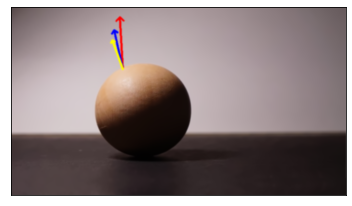

In [ ]:
copy_image = img.copy()

# Start point coordinates
center_y = math.floor(img.shape[0]/3)
center_x = math.floor(img.shape[1]/3)

# Start pixel
start_point = (center_x, center_y) 
  
# End point scale & coordinates
scale_LS = 0.9
scale_R = 1.0
scale_LIGHT = 70.0

light_angle = -110

end_pointLS = (math.floor(center_x + (Lx_LS*scale_LS)), math.floor(center_y + (Ly_LS*scale_LS)))
end_pointR = (math.floor(center_x + (Lx_R*scale_R)), math.floor(center_y + (Ly_R*scale_R)))
end_pointLIGHT = (math.floor(center_x + scale_LIGHT*(math.cos(np.deg2rad(light_angle)))), math.floor(center_y + scale_LIGHT*(math.sin(np.deg2rad(light_angle)))))

# Color
color_LS = (255, 0, 0)        # red
color_R = (0, 0, 255)         # blue
color_LIGHT = (255, 255, 0)   # yellow
  
# Arrow thickness
thickness = 4

# Draw arrow
copy_image = cv2.arrowedLine(copy_image, start_point, end_pointLS, color_LS, thickness)          # red
copy_image = cv2.arrowedLine(copy_image, start_point, end_pointR, color_R, thickness)            # blue
copy_image = cv2.arrowedLine(copy_image, start_point, end_pointLIGHT, color_LIGHT, thickness)    # yellow

show_image(copy_image, "")

# Save the image
im = Image.fromarray(copy_image)
im.save("sphere-result.png")

# STEP 7: COMPUTE ERRORS
Errors estimation

In [ ]:
# # Remember: Lx = L*cos(angle) and Ly = L*sin(angle)
# # Light magnitude 
# light_R = np.linalg.norm([Lx_R, Ly_R])      # RANSAC
# light_LS = np.linalg.norm([Lx_LS, Ly_LS])   # LS

# # Light components (RANSAC)
# Lx_ = Lx_R/light_R
# Ly_ = Ly_R/light_R

# # Light components (LS)
# Lx__ = Lx_LS/light_LS
# Ly__ = Ly_LS/light_LS

# # Angles
# print("Angles:")
# angle_R = np.rad2deg(math.acos(Lx_))
# angle_LS = np.rad2deg(math.acos(Lx__))
# print("RANSAC:", np.rad2deg(math.acos(Lx_))) # RANSAC
# print("LS:", np.rad2deg(math.acos(Lx__)))    # LS
# true_angle = -light_angle                    # origin in the top-left corner 
# print("Light:", true_angle)                  # "true"

# # Prediction
# y_pred_LS = linear_regr.predict(X_LS)
# y_pred_R = ransac.predict(X)

# # Nx
# plt.figure(1)
# plt.scatter(X[:,0], y)
# plt.plot(X_LS[:,0], y_pred_LS, color='red', linewidth=3, label='LS')
# plt.plot(X[:,0], y_pred_R, color='blue', linewidth=3, label='RANSAC')
# plt.xlabel("$N_x$")
# plt.ylabel("$y$")
# plt.legend()
# plt.show

# # Ny
# plt.figure(2)
# plt.scatter(X[:,1], y)
# plt.plot(X_LS[:,1], y_pred_LS, color='red', linewidth=3, label='LS')
# plt.plot(X[:,1], y_pred_R, color='blue', linewidth=3, label='RANSAC')
# plt.xlabel("$N_y$")
# plt.ylabel("$y$")
# plt.legend()
# plt.show

# # The mean squared error (MSE)
# print("----------------------------------")
# print('LS:')
# print('MSE: %.2f' % mean_squared_error(y_LS, y_pred_LS))
# # The coefficient of determination (1.0 is perfect prediction)
# print('Coefficient of determination: %.2f' % r2_score(y_LS, y_pred_LS))

# print('RANSAC:')
# # The mean squared error (MSE)
# print('MSE: %.2f' % mean_squared_error(y, y_pred_R))

# print('Coefficient of determination: %.2f' % r2_score(y, y_pred_R))

In [ ]:
# Prediction error
pred_error_LS = abs(true_angle - angle_LS)
pred_error_RANSAC = abs(true_angle - angle_R)

print("Prediction error LS:", pred_error_LS)
print("Prediction error RANSAC:", pred_error_RANSAC)

Prediction error LS: 16.994736024476637
Prediction error RANSAC: 7.5924601728978445
